<a href="https://colab.research.google.com/github/Mohand995/SelfDrivingCar/blob/main/SelfDrivingCar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The target is to predict the steering angle of the car**

In [1]:
import pandas as pd 
import numpy as np 
import sklearn 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imgaug import augmenters as iaa 
from sklearn.utils import shuffle
import cv2 
import random
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split

**Read_Data**

In [2]:
def importDataInfo(path):
    columns=['Center','Left','Right','Steering','Throttle','Brake','Speed']
    data=pd.read_csv(os.path.join(path,"driving_log.csv"),names=columns)
    data['Center']=data['Center'].apply(GetPath)
    data['Steering']=data['Steering'].str.replace('٫','.')
    data['Steering']=data['Steering'].astype("float64")
    return data

In [3]:
def GetPath(filepath):
    return filepath.split('/')[-1]

In [4]:
path="/content"
data=importDataInfo(path)

In [5]:
data.head()

,Center,Left,Right,Steering,Throttle,Brake,Speed
0,center_2022_12_10_11_50_40_319.jpg,/home/mohand/Desktop/IMG/left_2022_12_10_11_50...,/home/mohand/Desktop/IMG/right_2022_12_10_11_5...,0.0,0,0,28٫1638
1,center_2022_12_10_11_50_40_412.jpg,/home/mohand/Desktop/IMG/left_2022_12_10_11_50...,/home/mohand/Desktop/IMG/right_2022_12_10_11_5...,0.0,0,0,27٫93591
2,center_2022_12_10_11_50_40_483.jpg,/home/mohand/Desktop/IMG/left_2022_12_10_11_50...,/home/mohand/Desktop/IMG/right_2022_12_10_11_5...,0.0,0,0,27٫70986
3,center_2022_12_10_11_50_40_562.jpg,/home/mohand/Desktop/IMG/left_2022_12_10_11_50...,/home/mohand/Desktop/IMG/right_2022_12_10_11_5...,0.0,0,0,27٫48563
4,center_2022_12_10_11_50_40_644.jpg,/home/mohand/Desktop/IMG/left_2022_12_10_11_50...,/home/mohand/Desktop/IMG/right_2022_12_10_11_5...,0.0,0,0,27٫2632


In [6]:
print("size of dataset is {}".format(len(data)))

size of dataset is 1272


Mount Drive of another account

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Visualize data**

In [8]:
def Visualize_and_Balance(data,display=True):

  if display:
    sns.histplot(data['Steering'],bins=31);
    plt.title("data_before balancing")

  data_steering_0=data[data['Steering']==0.0]
  data_steering_not_0=data[data['Steering']!=0.0]
  data_steering_0=data_steering_0.sample(frac=1)
  data_steering_0=data_steering_0[:800]
  data_total=pd.concat([data_steering_0,data_steering_not_0],axis=0)
  data_total=data_total.sample(frac=1)

  if display:
    plt.figure()
    sns.histplot(data_total['Steering'],bins=31);
    plt.title("data_after balancing")

  return data_total


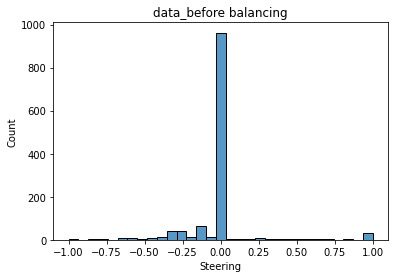

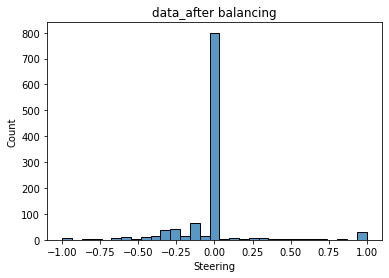

In [9]:
Data_Set=Visualize_and_Balance(data,display=True)

In [10]:
len(Data_Set)

1110

**Load data in memory**

In [11]:
def load_data_in_memory(Data,path):
  imgs_data=[]
  steering_data=[]
  for i in range(len(Data)):
    img_path=Data.iloc[i][0]
    img=os.path.join(path,img_path)
    steering_point=Data.iloc[i][3]
    imgs_data.append(img)
    steering_data.append(steering_point)
  return np.array(imgs_data),np.array(steering_data)

In [12]:
imgs,steering=load_data_in_memory(Data_Set,'/content/drive/MyDrive/IMG/')

In [13]:
print("no of images is {}".format(len(imgs)))
print("no of images is {}".format(len(steering)))

no of images is 1110
no of images is 1110


**Data_Augmentation**

In [14]:
def augment_image(image_path,steering):

    img=cv2.imread(image_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ################################################
    if np.random.rand()<0.5:
        img=cv2.flip(img,1)
        steering=steering*-1
    ##########################################################
    if np.random.rand()<0.5:
        h,w=img.shape[0],img.shape[1]
        M = cv2.getRotationMatrix2D((w/2,h/2), 20, 1)
        img= cv2.warpAffine(img,M,(w,h))
    ##########################################################
    if np.random.rand()<0.5:
        img = cv2.GaussianBlur(img,(5,5),0)
    ####################################################
    if np.random.rand()<0.5:
          hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
          value = 20
          hsv[:,:,2] -= value
          img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


    return img,steering

**Preprocessing**

YUV color model make the lane of the road more obvious

In [15]:
def Preprocessing(img):
    img=img[60:135,:]
    img=cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
    img=cv2.GaussianBlur(img,(3,3),0)
    img=cv2.resize(img,(200,66))
    img=img/255
    return img


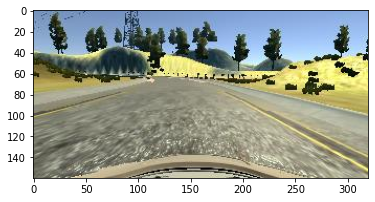

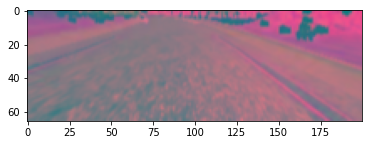

In [16]:
img_path=imgs[0]
first_img=cv2.imread(img_path)
first_img=cv2.cvtColor(first_img,cv2.COLOR_BGR2RGB)
plt.imshow(first_img)
plt.figure()
plt.imshow(Preprocessing(first_img))

In [23]:
def BatchGenerator(imgPath,steeringList,batchSiz,Train=True):
    while True:
        imgBatch=[]
        SteeringBatch=[]

        for i in range (batchSiz):
            index=random.randint(0,len(imgPath)-1)
            if Train :
                    img,steering=augment_image(imgPath[index],steeringList[index])
            else :
                img=mpimg.imread(imgPath[index])
                steering=steeringList[index]

            img=Preprocessing(img)
            imgBatch.append(img)
            SteeringBatch.append(steering)

        yield (np.array(imgBatch),np.array(SteeringBatch))

**Model**

In [18]:
def create_model():
  model=tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(24,(5,5),(2,2),input_shape=(66,200,3),activation='elu'))
  model.add(tf.keras.layers.Conv2D(36,(5,5),(2,2),activation='elu'))
  model.add(tf.keras.layers.Conv2D(48,(5,5),(2,2),activation='elu'))
  model.add(tf.keras.layers.Conv2D(64,(3,3),(1,1),activation='elu'))  
  model.add(tf.keras.layers.Conv2D(64,(3,3),(1,1),activation='elu'))  
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(100,activation='elu'))
  model.add(tf.keras.layers.Dense(50,activation='elu'))
  model.add(tf.keras.layers.Dense(10,activation='elu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(tf.keras.optimizers.Adam(lr=0.0001),tf.keras.losses.mse,tf.keras.metrics.mse)

  return model

In [19]:
model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
Xtrain,Xval,Ytrain,Yval=train_test_split(imgs,steering,test_size=0.1,random_state=1)
print(len(Xtrain))
print(len(Xval))

999
111


**Main**

In [27]:
path="/content"
data=importDataInfo(path)

#######Step2 Visualize Data###################
DataSet=Visualize_and_Balance(data,display=False)

######Step3 Prepare Data as lists################
path='/content/drive/MyDrive/IMG/'
imgs,steering=load_data_in_memory(DataSet,path)
##########Step4 SplitData########################
Xtrain,Xval,Ytrain,Yval=train_test_split(imgs,steering,test_size=0.1,random_state=1)
print(len(Xtrain))
print(len(Xval))
###################Create_Model#######################
model=create_model()

#####################train_model##############################
history=model.fit(BatchGenerator(imgs,steering,128,Train=True),steps_per_epoch=80,validation_data=BatchGenerator(imgs,steering,128,Train=False),validation_steps=80,epochs=10)



999
111


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
80/80 [==============================] - 63s 786ms/step - loss: 0.0656 - mean_squared_error: 0.0656 - val_loss: 0.0554 - val_mean_squared_error: 0.0554
Epoch 2/10
80/80 [==============================] - 60s 757ms/step - loss: 0.0555 - mean_squared_error: 0.0555 - val_loss: 0.0532 - val_mean_squared_error: 0.0532
Epoch 3/10
80/80 [==============================] - 61s 778ms/step - loss: 0.0525 - mean_squared_error: 0.0525 - val_loss: 0.0564 - val_mean_squared_error: 0.0564
Epoch 4/10
80/80 [==============================] - 57s 723ms/step - loss: 0.0501 - mean_squared_error: 0.0501 - val_loss: 0.0501 - val_mean_squared_error: 0.0501
Epoch 5/10
80/80 [==============================] - 57s 723ms/step - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0455 - val_mean_squared_error: 0.0455
Epoch 6/10
80/80 [==============================] - 58s 736ms/step - loss: 0.0450 - mean_squared_error: 0.0450 - val_loss: 0.0428 - val_mean_squared_error: 0.0428
Epoch 7/10
80/80 [====

In [28]:
model.save('self_driving_model.h5')

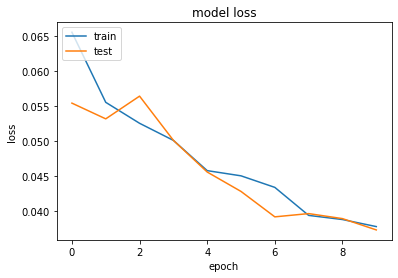

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()